# Commodity price forecasting using VECM models

In [1]:
library(vars)
library(tsDyn)
library(fpp2)
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(xts)
library(DMwR)
library(Metrics)
library(hydroGOF)

Loading required package: MASS
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: urca
Loading required package: lmtest
Loading required package: ggplot2
Loading required package: forecast
Loading required package: fma

Attaching package: ‘fma’

The following objects are masked from ‘package:MASS’:

    cement, housing, petrol

Loading required package: expsmooth

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

In [2]:
options(repr.plot.width=8, repr.plot.height=3)

## 1. Data import and analysis

In [3]:
data <- read.csv("data/gold-silver.csv", sep=';')
head(data)

Date,gold,silver
1993/11/01,369.25,4.25
1993/12/01,376.30,4.62
1994/01/01,394.00,5.24
1994/02/01,384.50,5.31
1994/03/01,378.75,5.32
1994/04/01,391.00,5.78


In [4]:
gold <- ts(data$gold, start = c(1993, 11), frequency = 12)
silver <- ts(data$silver, start = c(1993, 11), frequency = 12)

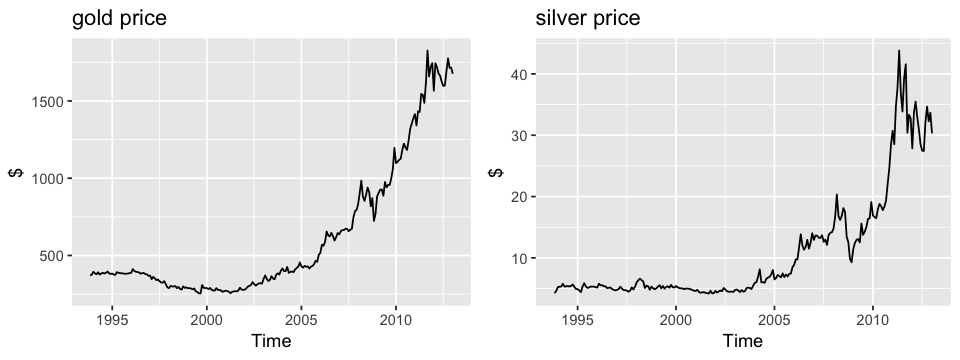

In [5]:
p1 <- ggplot2::autoplot(gold) + ggtitle('gold price') + ylab('$')
p2 <- ggplot2::autoplot(silver) + ggtitle('silver price') + ylab('$')

gridExtra::grid.arrange(p1, p2, ncol=2)

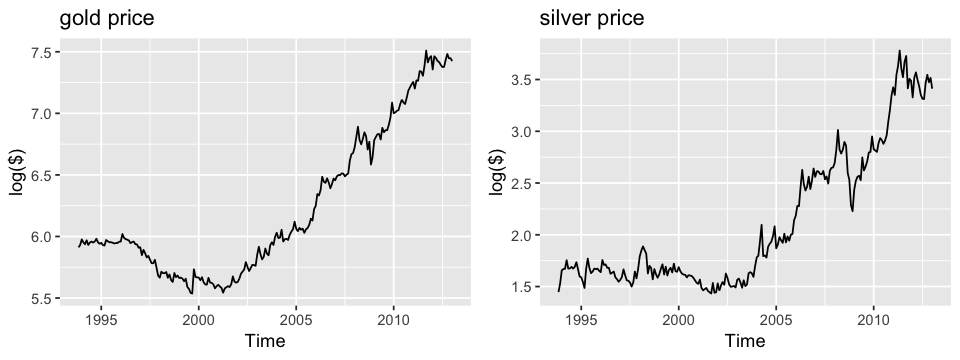

In [6]:
p3 <- ggplot2::autoplot(log(gold)) + ggtitle('gold price') + ylab('log($)')
p4 <- ggplot2::autoplot(log(silver)) + ggtitle('silver price') + ylab('log($)')

gridExtra::grid.arrange(p3, p4, ncol=2)

In [7]:
nrow(data)

[1] 231

## 2. Train test split

In [8]:
test_size <- as.numeric(12)
train_size <- length(gold) - test_size

train_gold <- head(gold, train_size)
test_gold <- tail(gold, test_size)

train_silver <- head(silver, train_size)
test_silver <- tail(silver, test_size)

## 3. Evaluation function

In [9]:
model_evaluation <- function(train, train_pred, test, test_pred){
        
        train_rmse <- sqrt(mse(train, train_pred))
        train_mae <- mae(train, train_pred)
        train_nrmse <- train_rmse/sd(train)

        test_rmse <- sqrt(mse(test, test_pred))
        test_mae <- mae(test, test_pred)
        test_nrmse <- test_rmse/sd(test)

        print(paste0('Training NRMSE :', round(train_nrmse, 3)))
        print(paste0('Training MAE :', round(train_mae, 3)))

        print(paste0('Test NRMSE :', round(test_nrmse, 3)))
        print(paste0('Test MAE :', round(test_mae, 3)))
    }

## 4. ACF and PACF plots

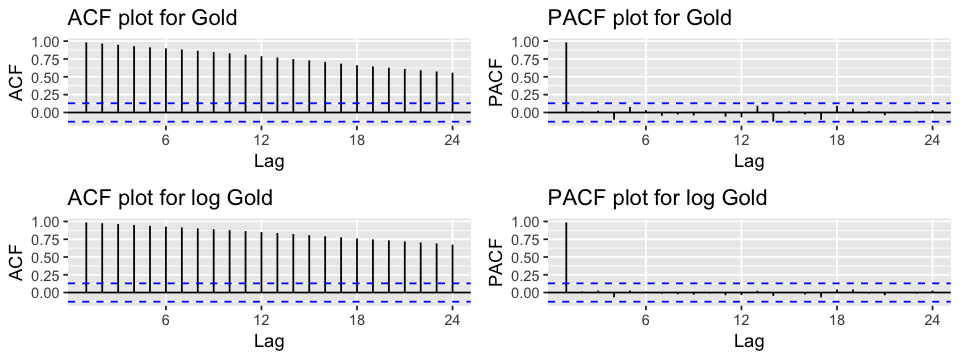

In [10]:
## ACF and PACF plots

p1 <- ggAcf(gold) + ggtitle('ACF plot for Gold')
p2 <- ggPacf(gold) + ggtitle('PACF plot for Gold')

p3 <- ggAcf(log(gold)) + ggtitle('ACF plot for log Gold')
p4 <- ggPacf(log(gold)) + ggtitle('PACF plot for log Gold')

gridExtra::grid.arrange(p1, p2, p3, p4, nrow=2)

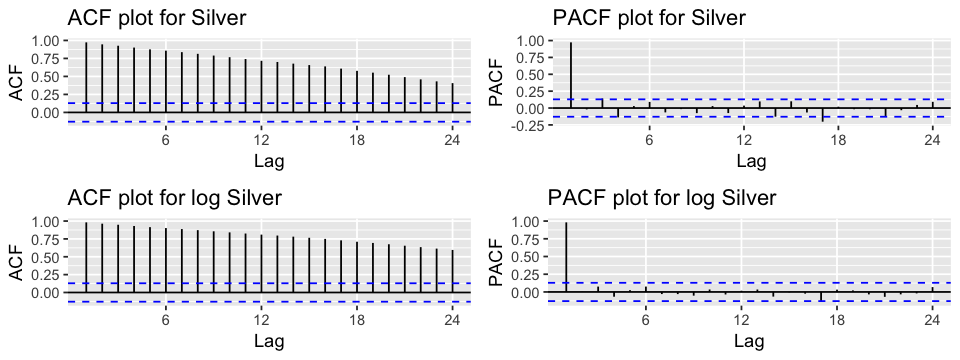

In [11]:
## ACF and PACF plots

p1 <- ggAcf(silver) + ggtitle('ACF plot for Silver')
p2 <- ggPacf(silver) + ggtitle('PACF plot for Silver')

p3 <- ggAcf(log(silver)) + ggtitle('ACF plot for log Silver')
p4 <- ggPacf(log(silver)) + ggtitle('PACF plot for log Silver')

gridExtra::grid.arrange(p1, p2, p3, p4, nrow=2)

## 5. Stationarity test

In [12]:
# with trend, drift and intercept
adf.gold <- ur.df(gold, type = "trend", selectlags = "AIC")
summary(adf.gold)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-187.305  -11.922   -1.068   10.914  222.579 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -6.434795   5.347826  -1.203 0.230142    
z.lag.1     -0.007011   0.010595  -0.662 0.508864    
tt           0.153478   0.068629   2.236 0.026311 *  
z.diff.lag  -0.234303   0.065331  -3.586 0.000411 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 39.98 on 225 degrees of freedom
Multiple R-squared:  0.07947,	Adjusted R-squared:  0.0672 
F-statistic: 6.475 on 3 and 225 DF,  p-value: 0.0003196


Value of test-statistic is: -0.6617 5.1554 4.384 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.99 -3.43 -3.13
p

In [13]:
# with trend, drift and intercept on log transformed data
adf.gold.log <- ur.df(log(gold), type = "trend", selectlags = "AIC")
summary(adf.gold.log)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.188979 -0.026569 -0.001586  0.024103  0.188728 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  6.410e-02  5.049e-02   1.270  0.20555   
z.lag.1     -1.309e-02  9.335e-03  -1.403  0.16210   
tt           2.168e-04  8.273e-05   2.620  0.00939 **
z.diff.lag  -1.717e-01  6.550e-02  -2.622  0.00934 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04515 on 225 degrees of freedom
Multiple R-squared:  0.05981,	Adjusted R-squared:  0.04727 
F-statistic: 4.771 on 3 and 225 DF,  p-value: 0.003035


Value of test-statistic is: -1.4027 5.041 4.439 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.99 -3

In [14]:
# with trend, drift and intercept
adf.silver <- ur.df(silver, type = "trend", selectlags = "AIC")
summary(adf.silver)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.4957  -0.3801  -0.0623   0.3309   6.6082 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.135916   0.219950  -0.618   0.5372  
z.lag.1     -0.037754   0.019417  -1.944   0.0531 .
tt           0.005737   0.002637   2.176   0.0306 *
z.diff.lag  -0.082261   0.067396  -1.221   0.2235  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.63 on 225 degrees of freedom
Multiple R-squared:  0.03051,	Adjusted R-squared:  0.01759 
F-statistic:  2.36 on 3 and 225 DF,  p-value: 0.0723


Value of test-statistic is: -1.9444 2.0714 2.4398 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.99 -3.43 -3.13
phi2  6.22  4

In [15]:
# with trend, drift and intercept on log transformed data
adf.silver.log <- ur.df(log(silver), type = "trend", selectlags = "AIC")
summary(adf.silver.log)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.303769 -0.048608 -0.006425  0.051870  0.195662 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.0333545  0.0219810   1.517   0.1306  
z.lag.1     -0.0306429  0.0167447  -1.830   0.0686 .
tt           0.0003491  0.0001671   2.089   0.0378 *
z.diff.lag  -0.0720055  0.0666563  -1.080   0.2812  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08551 on 225 degrees of freedom
Multiple R-squared:  0.02589,	Adjusted R-squared:  0.01291 
F-statistic: 1.994 on 3 and 225 DF,  p-value: 0.1158


Value of test-statistic is: -1.83 2.2871 2.1844 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.99 -3.43 -3.

## 6. Lag selection

In [16]:
# lag selection for actual data
data <- cbind(train_gold, train_silver)
colnames(data) <- c("gold", "silver")

lag.info <- VARselect(data, lag.max = 12, type = "trend")
print(lag.info$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    10      5      5     10 


In [17]:
# lag selection for log transformed data
data.log <- cbind(log(train_gold), log(train_silver))
colnames(data.log) <- c("gold.log", "silver.log")

lag.info.log <- VARselect(data.log, lag.max = 12, type = "trend")
print(lag.info.log$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      1      1      3 


## 7. VECM model

In [18]:
# vecm model
vecm.procedure <- ca.jo(data, ecdet = "const", type="eigen", K=10, spec="transitory")
summary(vecm.procedure)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  1.208176e-01  2.913536e-02 -1.487812e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  6.18  7.52  9.24 12.97
r = 0  | 26.91 13.75 15.67 20.20

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             gold.l1 silver.l1    constant
gold.l1      1.00000   1.00000     1.00000
silver.l1  -34.18524 -64.21810    89.21914
constant  -130.76726 -21.14914 -1864.89433

Weights W:
(This is the loading matrix)

             gold.l1     silver.l1      constant
gold.d   0.119698036 -0.0186080527 -3.909361e-18
silver.d 0.004157653  0.0009501876  7.692557e-20


In [19]:
vecm.ols <- cajorls(vecm.procedure, r = 1)

In [20]:
summary(vecm.ols)

     Length Class  Mode   
rlm  12     mlm    list   
beta  3     -none- numeric

In [21]:
vecm.ols$beta

,ect1
gold.l1,1.00000
silver.l1,-34.18524
constant,-130.76726


In [22]:
model <- vec2var(vecm.procedure)

## 8. Prediction

In [23]:
# test prediction
test.pred <- predict(model, n.ahead=12)

# gold and silver predicted values (log)
test.pred.gold <- test.pred$fcst[[1]]
test.pred.silver <- test.pred$fcst[[2]]

In [24]:
head(test.pred.gold)

fcst,lower,upper,CI
1554.197,1489.523,1618.870,64.67336
1633.893,1552.045,1715.740,81.84770
1541.170,1451.146,1631.195,90.02454
1535.945,1433.881,1638.008,102.06341
1535.614,1424.667,1646.562,110.94757
1562.733,1446.152,1679.314,116.58091


In [26]:
## train fitted values
train.pred <- fitted(model)


# gold and silver predicted values (log)
train.pred.gold <- train.pred[, 1]
train.pred.silver <- train.pred[, 2]

In [27]:
head(train.pred)

fit of gold,fit of silver
394.9863,5.334031
395.8996,5.432145
401.3311,5.838873
394.4600,5.744057
387.8725,5.130960
393.9562,5.453896


## 9. Evaluation

In [28]:
# convert prediction to ts object
# shift the train prediction as per lag value used
# no need to shift for test values
train.gold <- ts(tail(train_gold, -10), start = c(1994, 9), frequency = 12)
train.silver <- ts(tail(train_silver, -10), start = c(1994, 9), frequency = 12)

train.pred.g <- ts(train.pred.gold, start = c(1994, 9), frequency = 12)
train.pred.s <- ts(train.pred.silver, start = c(1994, 9), frequency = 12)

test.pred.g <- ts(test.pred.gold[, 1], start = c(2012, 2), frequency = 12)
test.pred.s <- ts(test.pred.silver[, 1], start = c(2012, 2), frequency = 12)

In [29]:
model_evaluation(train.gold, train.pred.g, test_gold, test.pred.g)

[1] "Training NRMSE :0.088"
[1] "Training MAE :22.439"
[1] "Test NRMSE :2.163"
[1] "Test MAE :104.97"


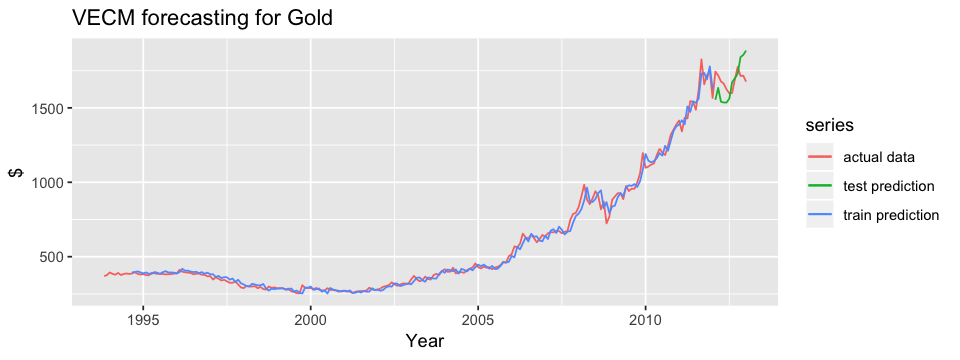

In [30]:
autoplot(gold, series = 'actual data') +
    autolayer(train.pred.g, series = 'train prediction') +
    autolayer(test.pred.g, series = 'test prediction') +
    xlab('Year') +
    ylab('$') +
    ggtitle('VECM forecasting for Gold')

In [31]:
model_evaluation(train.silver, train.pred.s, test_silver, test.pred.s)

[1] "Training NRMSE :0.149"
[1] "Training MAE :0.817"
[1] "Test NRMSE :3.127"
[1] "Test MAE :7.4"


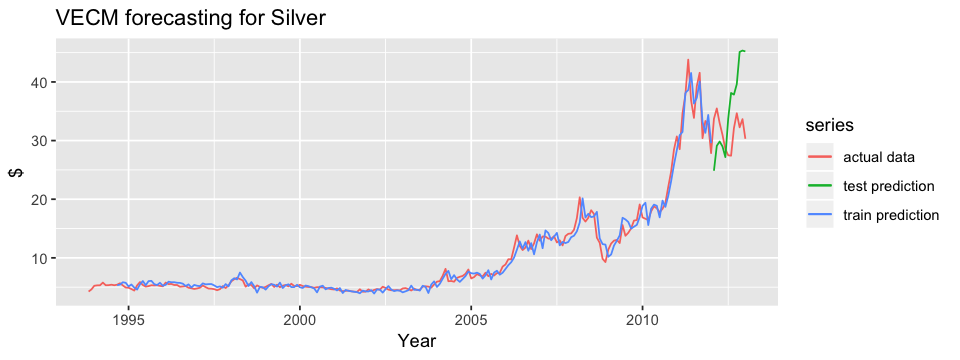

In [32]:
autoplot(silver, series = 'actual data') +
    autolayer(train.pred.s, series = 'train prediction') +
    autolayer(test.pred.s, series = 'test prediction') +
    xlab('Year') +
    ylab('$') +
    ggtitle('VECM forecasting for Silver')

In [33]:
options(repr.plot.width=8, repr.plot.height=5)

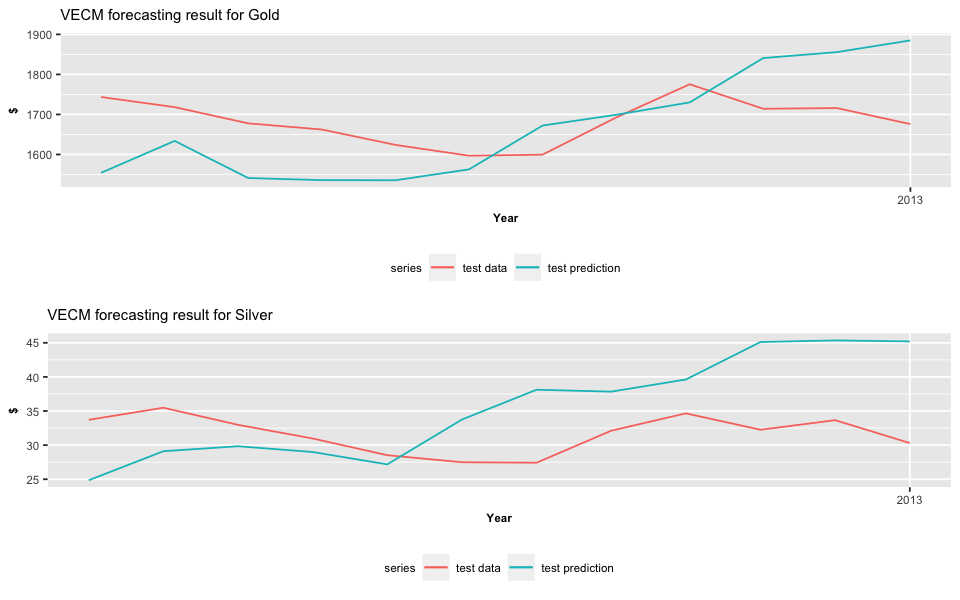

In [34]:
g1 <- autoplot(test_gold, series = 'test data') +
        autolayer(test.pred.g, series = 'test prediction') +
        xlab('Year') +
        ylab('$') +
        ggtitle('VECM forecasting result for Gold') +
        theme(plot.title = element_text(size=9))+
        theme(legend.position="bottom") +
        theme(legend.title = element_text(size = 7), 
               legend.text = element_text(size = 7))+
        theme(axis.text=element_text(size=7),
        axis.title=element_text(size=7,face="bold"))

g2 <- autoplot(test_silver, series = 'test data') +
        autolayer(test.pred.s, series = 'test prediction') +
        xlab('Year') +
        ylab('$') +
        ggtitle('VECM forecasting result for Silver') +
        theme(plot.title = element_text(size=9)) +
        theme(legend.position="bottom") +
        theme(legend.title = element_text(size = 7), 
               legend.text = element_text(size = 7)) +
        theme(axis.text=element_text(size=7),
        axis.title=element_text(size=7,face="bold"))

gridExtra::grid.arrange(g1, g2, nrow=2)